<a href="https://colab.research.google.com/github/XaviJunior/SBB/blob/master/project_2/Code/Team_SBB_project_2_Tarik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real or Not? NLP with Disaster Tweets (Kaggle Competition)

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo("", width=600)

[Link to the GitHub repository](https://github.com/XaviJunior/SBB)

[Link to the YouTube video]()

## Contributions

* **Xavier AEBY**: 
* **Tarik BACHA**: 
* **Tanguy BERGUERAND**: 
* **Frederic SPYCHER**: 

## Introduction

For our second group project, we were tasked with joining the [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started) Kaggle competition, which consists of devising a machine learning model that can predict, using natural language processing, whether tweets announcing a disaster are genuine or not.

The incentive for such a model is to assist disaster relief organizations and news agencies identify actual   as they monitor Twitter (which is often used as a communication tool during such events).

## Setting things up

In [35]:
#!pip install spacy
#!pip install xgboost
!pip install keras

In [0]:
import re
import string

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import keras

RSEED = 42

## The data

The data provided by Kaggle contains more than **10,000 tweets**, for 70% of which we are given their `target` class (1 = true, 0 = false). Each observation from the training data is composed of an `id` and the `text` of the tweet. In some cases, a `keyword` as well as the tweet's `location` are also given.

In [37]:
df = pd.read_csv("https://raw.githubusercontent.com/XaviJunior/SBB/master/project_2/Data/train.csv", encoding="utf-8")
df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [38]:
print("Classified observations:", df.shape[0])

Classified observations: 7613


In [39]:
df_test = pd.read_csv("https://raw.githubusercontent.com/XaviJunior/SBB/master/project_2/Data/test.csv", encoding="utf-8")
df_test.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [0]:
len(df_test.text[0])

34

## Cleaning

In [0]:
def clean(tweet):
    tweet = re.sub(r"\b[0-9]+\b", "", tweet)  # remove tokens with numbers only
    tweet = re.sub(r"@[A-Za-z0-9_]+", "", tweet)  # remove Twitter usernames
    tweet = re.sub(r"\bRT\b", "", tweet)  # remove "RT"
    tweet = re.sub(r" \w{1,3}\.{3,3} http\S{0,}", " ", tweet)  # remove truncated endings
    tweet = re.sub(r"http\S{0,}", " ", tweet)  # remove other URLs
    tweet = re.sub(r".Û.", "'", tweet)  # replace strange representation of apostrophe
    
    # replace HTML codes
    tweet = re.sub(r"&amp;", "&", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&gt;", ">", tweet)
    
    tweet = re.sub(r"[^a-zA-Z0-9']", " ", tweet)  # keep alphanumerical characters only
    tweet = re.sub(r"\bx....\b", " ", tweet)  # remove hexadecimal characters
    tweet = re.sub(r"\s+|\t|\n", " ", tweet)  # remove all white spaces, tabs and newlines
    
    #tweet = detect_elongated_words(tweet)
    
    return tweet.strip()
    
df["text"] = df["text"].apply(clean)
df_test["text"] = df_test["text"].apply(clean)

# df["text"].to_csv("tweets.csv", index=False)

## DataViz

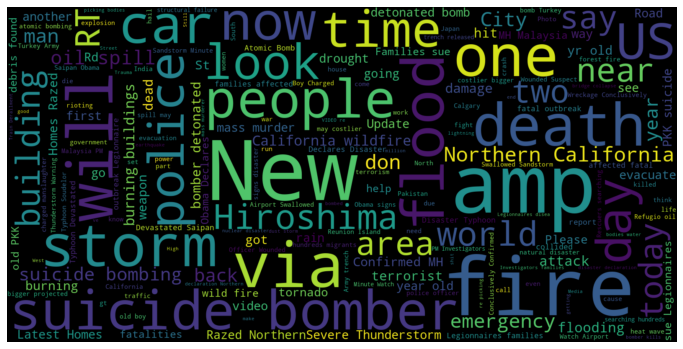

In [0]:
from wordcloud import WordCloud
tweets_Cata = df[df['target']==1]
Cata_stringT = []
Cata_stringT=[t for t in tweets_Cata['text']]
Cata_string = pd.Series(Cata_stringT).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(Cata_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(ngram_range=(2,2))
cvec.fit(df["text"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(2, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
print("number of feature identify by the CountVectorizer =",len(cvec.get_feature_names()))

number of feature identify by the CountVectorizer = 59419


In [0]:
#crée un df qui sum le nombre d'apparition de chaine de caractère !
def token_counter(df, minGram, maxGram):
  from sklearn.feature_extraction.text import CountVectorizer
  minGram = minGram
  maxGram = maxGram
  df = df
  cvec = CountVectorizer(ngram_range=(minGram,maxGram), stop_words='english')
  cvec.fit(df["text"])
  NoCata_doc_matrix = cvec.transform(df[df["target"] == 0].text)
  Cata_doc_matrix = cvec.transform(df[df["target"] == 1].text)
  NoCata_tf = np.sum(NoCata_doc_matrix,axis=0)
  Cata_tf = np.sum(Cata_doc_matrix,axis=0)
  NoCata = np.squeeze(np.asarray(NoCata_tf))
  Cata = np.squeeze(np.asarray(Cata_tf))
  term_freq_df = pd.DataFrame([NoCata,Cata],columns=cvec.get_feature_names()).transpose()
  term_freq_df.columns = ['Nothing', 'Disaster']
  term_freq_df['total'] = term_freq_df['Nothing'] + term_freq_df['Disaster']
  return term_freq_df
#term_freq_df.head()

In [0]:
dfViz = pd.DataFrame()
dfViz = token_counter(df,2,2)

In [0]:
dfViz.sort_values(by='total', ascending=False).iloc[:10]

,Nothing,Disaster,total
suicide bomber,0,59,59
burning buildings,23,36,59
youtube video,36,7,43
liked youtube,35,7,42
northern california,0,41,41
cross body,39,1,40
oil spill,1,38,39
suicide bombing,1,35,36
year old,6,28,34
california wildfire,0,34,34


## Tokenization

In [0]:
nlp = English()
punctuation = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def tokenizer(tweet):
    tokens = nlp(tweet)
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    
    return tokens

#vectorizer = TfidfVectorizer(tokenizer=tokenizer, ngram_range=(1,1))
vectorizer = CountVectorizer(tokenizer=tokenizer, ngram_range=(1,1))

## Training models

For our first attempts at building a model, we went back to models previously seen in the Data Mining & Machine Learning and Big-Scale Analytics courses, without tweaking the hyperparamaters too much, in order to compare how they each perform with this particular dataset.

Preparing the data: needs to be in the form of the list

In [42]:
X = vectorizer.fit_transform(df["text"].values.tolist())
y = df["target"].values.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

X_train

<6090x15973 sparse matrix of type '<class 'numpy.int64'>'
	with 52046 stored elements in Compressed Sparse Row format>

In [43]:
X1 = df["text"]
y1 = df['target']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=RSEED)
X_train1.isnull().sum()

0

### Random forest

In [0]:
RF = RandomForestClassifier(criterion="entropy", n_estimators=30, max_depth=200, random_state=RSEED)
RF.fit(X_train, y_train)
f1_score(y_test, RF.predict(X_test)) #0.6904 // #sans ponctuation:0.7125000000000001 // #fullLowerCase_SansPonctuation:0.7125000000000001

0.7125000000000001

### XGBoost

In [0]:
xgc = xgb.XGBClassifier(n_estimators=101, max_depth=71, base_score=0.5, objective='binary:logistic', random_state=RSEED)
xgc.fit(X_train, y_train)
f1_score(y_test, xgc.predict(X_test)) #0.73411 // #sans ponctuation:0.7376 // #fullLowerCase_SansPonctuation:0.737611

0.7376116978066614

### Neural network1

In [0]:
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta,Adam,RMSprop
from keras.utils import np_utils
from tensorflow.keras import regularizers

nb_classes = 2
batch_size = 512 #recommended 32
nb_epochs = 24 #recommended 50-100

X3 = df["text"]
y3 = df["target"]

from keras.utils import to_categorical
vectorizer = TfidfVectorizer(tokenizer=tokenizer, ngram_range=(1,1))#, max_features= max_words)
#vectorizer = CountVectorizer(tokenizer=tokenizer, ngram_range=(1,1))#, max_features= max_words)
X3 = vectorizer.fit_transform(df["text"].values.tolist())
y3 = to_categorical(df["target"].values.tolist())

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=RSEED)

tup1=X_train3.shape
max_words = tup1[1]

In [0]:
NN = Sequential()
NN.add(Dense(16, input_shape=(max_words,), activation='relu'))
NN.add(Dropout(0.5))
NN.add(Dense(16,activation='relu'))
NN.add(Dropout(0.5))
NN.add(Dense(2, activation='sigmoid'))

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
NN.compile(loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy',f1_m,precision_m, recall_m])

In [211]:
NN.fit(X_train3, y_train3, batch_size=batch_size, epochs=nb_epochs,verbose=1, validation_split=0.2)

Train on 4872 samples, validate on 1218 samples
Epoch 1/24
4872/4872 [==============================] - 1s 170us/step - loss: 0.6922 - accuracy: 0.5460 - f1_m: 0.5680 - precision_m: 0.5417 - recall_m: 0.5975 - val_loss: 0.6907 - val_accuracy: 0.5616 - val_f1_m: 0.5616 - val_precision_m: 0.5616 - val_recall_m: 0.5616
Epoch 2/24
4872/4872 [==============================] - 1s 133us/step - loss: 0.6886 - accuracy: 0.5627 - f1_m: 0.5716 - precision_m: 0.5588 - recall_m: 0.5850 - val_loss: 0.6870 - val_accuracy: 0.5616 - val_f1_m: 0.5616 - val_precision_m: 0.5616 - val_recall_m: 0.5616
Epoch 3/24
4872/4872 [==============================] - 1s 136us/step - loss: 0.6831 - accuracy: 0.5664 - f1_m: 0.5714 - precision_m: 0.5624 - recall_m: 0.5807 - val_loss: 0.6818 - val_accuracy: 0.5616 - val_f1_m: 0.5616 - val_precision_m: 0.5616 - val_recall_m: 0.5616
Epoch 4/24
4872/4872 [==============================] - 1s 133us/step - loss: 0.6751 - accuracy: 0.5807 - f1_m: 0.5874 - precision_m: 0.5796 -

In [212]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = NN.evaluate(X_test3, y_test3, verbose=0)
print("loss=",loss)
print("accuracy=",accuracy)
print("f1_score=",f1_score)
print("precision=",precision)
print("recall=",recall)

loss= 0.48516755536912853
accuracy= 0.772488534450531
f1_score= 0.7732117772102356
precision= 0.7653362154960632
recall= 0.7815926671028137


###NN2

In [0]:
NN2 = Sequential()
NN2.add(Dense(32, input_shape=(max_words,), activation='relu'))
NN2.add(Dropout(0.5))
NN2.add(Dense(32, activation='relu'))
NN2.add(Dense(nb_classes, activation='sigmoid'))

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
NN2.compile(loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy',f1_m,precision_m, recall_m])

In [226]:
batch_size2 = 512 #recommended 32
nb_epochs2 = 10 #recommended 50-100
NN2.fit(X_train3, y_train3, batch_size=batch_size2, epochs=nb_epochs2,verbose=1, validation_split=0.2)

Train on 4872 samples, validate on 1218 samples
Epoch 1/10
4872/4872 [==============================] - 1s 168us/step - loss: 0.6913 - accuracy: 0.5578 - f1_m: 0.5592 - precision_m: 0.5545 - recall_m: 0.5642 - val_loss: 0.6884 - val_accuracy: 0.5616 - val_f1_m: 0.5616 - val_precision_m: 0.5616 - val_recall_m: 0.5616
Epoch 2/10
4872/4872 [==============================] - 1s 140us/step - loss: 0.6828 - accuracy: 0.5729 - f1_m: 0.5755 - precision_m: 0.5747 - recall_m: 0.5764 - val_loss: 0.6798 - val_accuracy: 0.5653 - val_f1_m: 0.5681 - val_precision_m: 0.5656 - val_recall_m: 0.5707
Epoch 3/10
4872/4872 [==============================] - 1s 139us/step - loss: 0.6678 - accuracy: 0.5827 - f1_m: 0.5868 - precision_m: 0.5831 - recall_m: 0.5905 - val_loss: 0.6650 - val_accuracy: 0.5973 - val_f1_m: 0.6149 - val_precision_m: 0.5950 - val_recall_m: 0.6364
Epoch 4/10
4872/4872 [==============================] - 1s 138us/step - loss: 0.6426 - accuracy: 0.6291 - f1_m: 0.6411 - precision_m: 0.6274 -

In [227]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = NN2.evaluate(X_test3, y_test3, verbose=0)
print("loss=",loss)
print("accuracy=",accuracy)
print("f1_score=",f1_score)
print("precision=",precision)
print("recall=",recall)

loss= 0.4804722034688538
accuracy= 0.7928430438041687
f1_score= 0.7904341220855713
precision= 0.7922003269195557
recall= 0.7887541651725769


###Doc2Vec

In [0]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')

data = df_test

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]

max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")


from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize("Hurrican on Atlanta Downtown".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)


# find most similar doc from the test data
mSimilar = model.docvecs.most_similar(positive=[model.infer_vector(test_data)],topn=5)
print("top 5 similar", mSimilar)


# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)

# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27


/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteration 78
iteration 79
iteration 80
iteration 81
iteration 82
iteration 83
iteration 84
iteration 85
iteration 86
iteration 87
iteration 88
iteration 89
iteration 90
iteration 91
iteration 92
iteration 93
iteration 94
iteration 95
iteration 96
iteration 97
iteration 98
iteration 99
Model Saved
V1_infer [ 0.00226323  0.0186646  -0.00841555  0.001

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Logistic Regression

In [0]:
LR = LogisticRegressionCV(solver="lbfgs", cv=5, max_iter=1000, random_state=RSEED)
LR.fit(X_train, y_train)
f1_score(y_test, LR.predict(X_test)) #0.746908 (base) // #sans ponctuation:0.7504 // #fullLowerCase_SansPonctuation:0.750413223140496

###Lime

In [0]:
#!pip install lime
from lime import lime_text
from sklearn.pipeline import make_pipeline
#Lime with Random Forest
cRF = make_pipeline(vectorizer, RF)
cBOOST = make_pipeline(vectorizer, xgc)
#cNN = make_pipeline(vectorizer, NN)
cLR = make_pipeline(vectorizer, LR)

#text explainer
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=[0,1])

In [0]:
def LimePlot (classifier, vectorizer, dfText, dfTarget, row):
  c = make_pipeline(vectorizer,classifier)
  idx = row
  exp = explainer.explain_instance(dfText[idx], c.predict_proba, num_features=8) #Change model accordingely : cRF = RandomForest // cBOOST = xgBoost // cNN = Neural Network // cLR = Logistic Regression
  print('True class: %s' % dfTarget[idx])
  exp.show_in_notebook(text=True)

In [0]:
LimePlot(LR, vectorizer, df['text'], df['target'], 12) #(Classifier, dataframeText, dataframeTarget, rowNumber)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


True class: 1


###Shap

## Exporting predictions

In [0]:
To send our submissions for the Kaggle competition, we compute predictions for a set of tweets provided by the website and send them in a CSV file containing the tweet `id` and the predicted `target` 

In [0]:
from google.colab import files

X = vectorizer.transform(df_test["text"].values.tolist())
df_test["target"] = NN2.predict_classes(X)  # modify with appropriate model (.predict_classes() pour les NN)

df_test[["id", "target"]].to_csv("UNIL_SBB_FSP.csv", index=False)
files.download("UNIL_SBB_FSP.csv")

## Unused code

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.pipeline import Pipeline
text_clf = Pipeline([
('vect', CountVectorizer()),
('tfidf', TfidfTransformer()),
('clf',MultinomialNB()),])

text_clf.fit(Text_train, y_train)
print(text_clf.score(Text_test,y_test))

0.5653315824031516


In [0]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import layers

input_dim = bow_train.shape[1] 
model = Sequential()
model.add(layers.Dense(600, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(200))
model.add(layers.Dense(150))
model.add(layers.Dense(10))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [0]:
model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 600)               11014800  
_________________________________________________________________
dense_2 (Dense)              (None, 200)               120200    
_________________________________________________________________
dense_3 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1510      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 11,166,671
Trainable params: 11,166,671
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(bow_train, y_train, epochs=10, batch_size=50)
loss, accuracy = model.evaluate(bow_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy)) #0.7525

Epoch 1/10
6090/6090 [==============================] - 23s 4ms/step - loss: 0.6881 - accuracy: 0.5576
Epoch 2/10
6090/6090 [==============================] - 22s 4ms/step - loss: 0.5235 - accuracy: 0.7635
Epoch 3/10
6090/6090 [==============================] - 22s 4ms/step - loss: 0.2059 - accuracy: 0.9320
Epoch 4/10
6090/6090 [==============================] - 22s 4ms/step - loss: 0.1203 - accuracy: 0.9553
Epoch 5/10
6090/6090 [==============================] - 22s 4ms/step - loss: 0.0826 - accuracy: 0.9695
Epoch 6/10
6090/6090 [==============================] - 22s 4ms/step - loss: 0.0561 - accuracy: 0.9796
Epoch 7/10
6090/6090 [==============================] - 23s 4ms/step - loss: 0.0418 - accuracy: 0.9841
Epoch 8/10
6090/6090 [==============================] - 22s 4ms/step - loss: 0.0349 - accuracy: 0.9857
Epoch 9/10
6090/6090 [==============================] - 23s 4ms/step - loss: 0.0290 - accuracy: 0.9882
Epoch 10/10
6090/6090 [==============================] - 22s 4ms/step - l

In [0]:
loss, accuracy = model.evaluate(bow_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.5102
